In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc
from sklearn.utils.class_weight import compute_class_weight

# Keras Imports (including Callbacks)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Add src to path
sys.path.append('../src')
from src.preprocess import normalize_flux

print("TensorFlow Version:", tf.__version__)

# --- 1. Load and Preprocess Data ---
TRAIN_PATH = '../data/raw/train.csv'
TEST_PATH = '../data/raw/test.csv'

print("Loading data...")
df_train = pd.read_csv(TRAIN_PATH)
df_test = pd.read_csv(TEST_PATH)

df_train['LABEL'] = df_train['LABEL'].map({1: 0, 2: 1})
df_test['LABEL'] = df_test['LABEL'].map({1: 0, 2: 1})

X_train_raw = df_train.drop('LABEL', axis=1)
y_train = df_train['LABEL']
X_test_raw = df_test.drop('LABEL', axis=1)
y_test = df_test['LABEL']

X_train_filled = X_train_raw.fillna(0)
X_test_filled = X_test_raw.fillna(0)

print("Normalizing data (detrending)...")
X_train_normalized = X_train_filled.apply(normalize_flux, axis=1).values
X_test_normalized = X_test_filled.apply(normalize_flux, axis=1).values

print("Reshaping data for CNN...")
X_train_cnn = X_train_normalized[:, :, np.newaxis]
X_test_cnn = X_test_normalized[:, :, np.newaxis]

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = {
    0: class_weights[0],
    1: class_weights[1]
}
print("--- Data preparation complete ---")


# --- 2. Model Architecture (v4) ---
# (Identical to v2/v3, our simplified 409k param model)
print("Building v4 model architecture...")
INPUT_SHAPE = (X_train_cnn.shape[1], 1)

model_v4 = Sequential([
    Input(shape=INPUT_SHAPE),
    Conv1D(filters=8, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    Conv1D(filters=16, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    Conv1D(filters=32, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    Flatten(),
    Dense(32, activation='relu'),
    Dropout(0.6),
    Dense(1, activation='sigmoid')
])

model_v4.summary()

TensorFlow Version: 2.20.0
Loading data...
Normalizing data (detrending)...
Reshaping data for CNN...
--- Data preparation complete ---
Building v4 model architecture...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 3193, 8)        │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 1596, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1596, 8)        │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 1592, 16)       │           656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 796, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 796, 16)        │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 792, 32)        │         2,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 396, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 396, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12672)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │       405,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 409,089 (1.56 MB)

 Trainable params: 408,977 (1.56 MB)

 Non-trainable params: 112 (448.00 B)

In [2]:
# Path to save our new best model
MODEL_SAVE_PATH = '../models/cnn_model_v4.keras'

# 1. ModelCheckpoint (Our safety net)
# We will save the model that gets the highest 'val_pr_auc'
checkpoint_cb = ModelCheckpoint(
    filepath=MODEL_SAVE_PATH,
    monitor='val_pr_auc',
    mode='max',
    save_best_only=True,
    verbose=1
)

# 2. EarlyStopping (To stop the instability)
# We will stop if 'val_pr_auc' doesn't improve for 5 epochs
early_stopping_cb = EarlyStopping(
    monitor='val_pr_auc',
    mode='max',
    patience=5,
    verbose=1,
    restore_best_weights=True # This is the magic!
)

CALLBACK_LIST = [checkpoint_cb, early_stopping_cb]

# 3. Compile with the HIGH learning rate (from v2)
print("Compiling v4 model with HIGH learning rate (0.001)...")
pr_auc_metric = AUC(curve='PR', name='pr_auc')

model_v4.compile(
    optimizer=Adam(learning_rate=0.001), # <--- KEY CHANGE: Back to 0.001
    loss='binary_crossentropy',
    metrics=['accuracy', pr_auc_metric]
)

print("Model compiled.")

Compiling v4 model with HIGH learning rate (0.001)...
Model compiled.


In [3]:
print("Starting v4 training...")
print("We expect this to be unstable, but for callbacks to save the peak.")

history_v4 = model_v4.fit(
    X_train_cnn,
    y_train,
    epochs=50, # Set a high number, EarlyStopping will handle it
    batch_size=32,
    validation_data=(X_test_cnn, y_test),
    class_weight=class_weight_dict,
    callbacks=CALLBACK_LIST # Pass our safety nets
)

print("Training finished.")

Starting v4 training...
We expect this to be unstable, but for callbacks to save the peak.
Epoch 1/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7053 - loss: 2.4522 - pr_auc: 0.0103
Epoch 1: val_pr_auc improved from None to 0.01428, saving model to ../models/cnn_model_v4.keras
159/159 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.6927 - loss: 2.2008 - pr_auc: 0.0097 - val_accuracy: 0.9912 - val_loss: 0.1319 - val_pr_auc: 0.0143
Epoch 2/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5933 - loss: 1.9321 - pr_auc: 0.0255
Epoch 2: val_pr_auc did not improve from 0.01428
159/159 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.5231 - loss: 1.5436 - pr_auc: 0.0209 - val_accuracy: 0.9368 - val_loss: 0.6305 - val_pr_auc: 0.0083
Epoch 3/50
157/159 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.3287 - loss: 1.1884 - pr_auc: 0.0442
Epoch 3: val_pr_auc improved from 0.01428 to 0.02716, saving model to ../models/cnn_model_v4.keras
159/159 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step

Evaluating model v4 (with best weights)...
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

Confusion Matrix (CNN v4):
[[563   2]
 [  5   0]]

Classification Report (CNN v4):
               precision    recall  f1-score   support

No Planet (0)       0.99      1.00      0.99       565
   Planet (1)       0.00      0.00      0.00         5

     accuracy                           0.99       570
    macro avg       0.50      0.50      0.50       570
 weighted avg       0.98      0.99      0.99       570


Plotting training history...


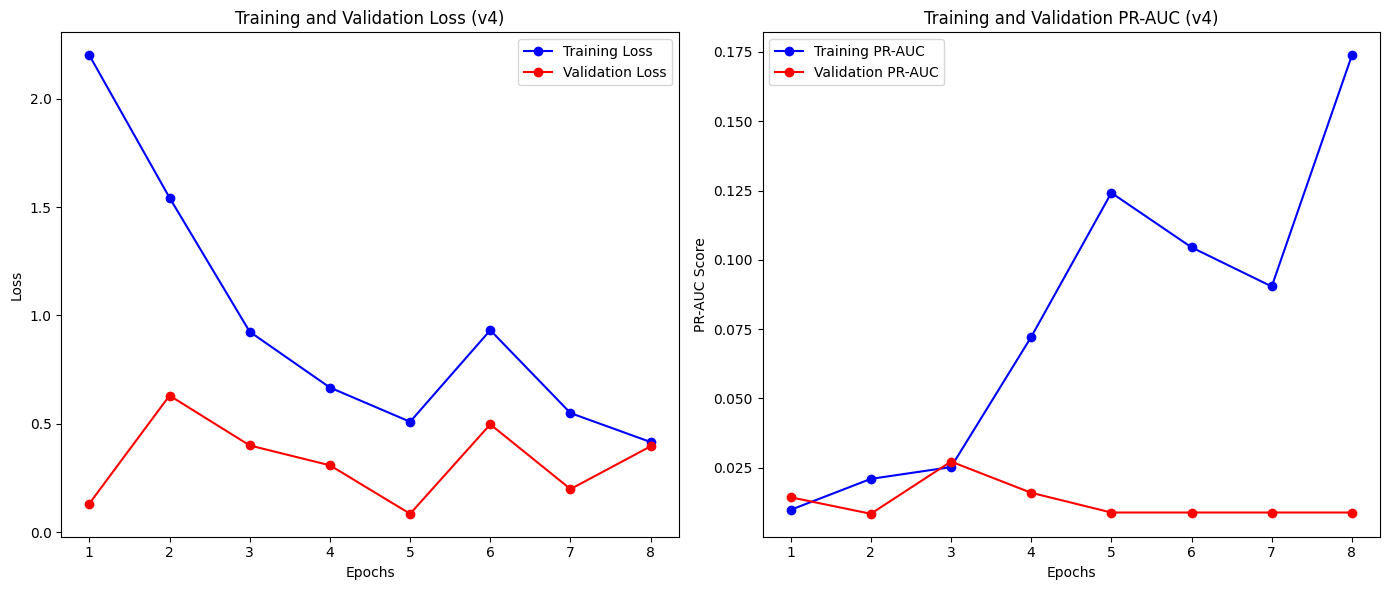

In [4]:
# 'restore_best_weights=True' means 'model_v4' is already the best model

print("Evaluating model v4 (with best weights)...")

y_pred_proba_cnn_v4 = model_v4.predict(X_test_cnn).flatten()
y_pred_cnn_v4 = (y_pred_proba_cnn_v4 > 0.5).astype(int)

print("\nConfusion Matrix (CNN v4):")
cm_cnn_v4 = confusion_matrix(y_test, y_pred_cnn_v4)
print(cm_cnn_v4)

print("\nClassification Report (CNN v4):")
print(classification_report(y_test, y_pred_cnn_v4, target_names=['No Planet (0)', 'Planet (1)']))

# --- 6. Plot Training History ---
print("\nPlotting training history...")

history_dict = history_v4.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']
pr_auc = history_dict['pr_auc']
val_pr_auc = history_dict['val_pr_auc']
actual_epochs = len(loss)
epochs_range = range(1, actual_epochs + 1)

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, 'bo-', label='Training Loss')
plt.plot(epochs_range, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss (v4)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, pr_auc, 'bo-', label='Training PR-AUC')
plt.plot(epochs_range, val_pr_auc, 'ro-', label='Validation PR-AUC')
plt.title('Training and Validation PR-AUC (v4)')
plt.xlabel('Epochs')
plt.ylabel('PR-AUC Score')
plt.legend()

plt.tight_layout()
plt.show()